In [1]:
# Import Block
import pandas as pd
import urllib.request
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# ========= Scraping and Analysing Northeast Regional Train 82 Delays =========

# Scraping Train 82 Delay Data from Amtrack Status Map Archive Database
# (https://juckins.net/amtrak_status/archive/html/home.php)

# Retriving Web Page HTML
url_DelayData = "https://juckins.net/amtrak_status/archive/html/history.php?train_num=82&station=&date_start=01%2F01%2F2010&date_end=12%2F31%2F2022&df1=1&df2=1&df3=1&df4=1&df5=1&df6=1&df7=1&sort=schDp&sort_dir=DESC&co=gt&limit_mins=&dfon=1"
req = urllib.request.Request(url_DelayData, headers={'User-Agent': 'Mozilla/5.0'})
delay_data_html = urllib.request.urlopen(req).read()

print(delay_data_html)

# Extracting the HTML Table as a panda DataFrame
train_data = pd.read_html(delay_data_html, header = 1)[0]

#Verifiying Data Retrival
train_data
train_data.dtypes

b'\n<!DOCTYPE HTML>\n\n<html lang="en">\n<head>\n<!-- Google tag (gtag.js) -->\n<script async src="https://www.googletagmanager.com/gtag/js?id=G-H73C69DFBC"></script>\n<script>\n  window.dataLayer = window.dataLayer || [];\n  function gtag(){dataLayer.push(arguments);}\n  gtag(\'js\', new Date());\n\n  gtag(\'config\', \'G-H73C69DFBC\');\n</script>\n<meta name="generator" content="HTML Tidy for Linux (vers 25 March 2009), see www.w3.org">\n<title>ASMAD - Amtrak Status Maps Archive Database - Train History Search</title>\n<meta name="description" content="ASMAD - Amtrak Status Maps History and Archive">\n<meta name="keywords" content="ASMAD - Search Past Amtrak Performance, Historical Amtrak on-time performance data, Amtrak Status Maps history, Amtrak Status Maps archive, statusmaps history, statusmaps.com history, statusmaps archive, statusmaps.com archive">\n<meta name="author" content="Christopher Juckins">\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n<meta n

Origin Date           object
Station               object
Sch Dp                object
Act Dp                object
Comments              object
Service Disruption    object
Cancellations         object
dtype: object

In [3]:
# Cleaning Data By Droping Last 2 Rows
train_data = train_data.drop([18544, 18545])

# Droping missing departure and delay data
train_data = train_data.dropna(subset=['Sch Dp', 'Comments'])

#Droping Times Where the comment has an error
train_data = train_data[train_data['Comments'] != 'Sa']

#Droping times where the station stop was cancled
train_data = train_data[train_data['Comments'] != 'Station Stop Canceled']
train_data = train_data[train_data['Comments'] != 'Sa Station Stop Canceled']

train_data.describe()
train_data.head()

Origin Date Station                   Sch Dp  Act Dp          Comments  \
0  12/31/2022 (Sa)     BBY  12/31/2022 6:22 PM (Sa)  6:42PM  Dp: 20 min late.   
1  12/31/2022 (Sa)     RTE  12/31/2022 6:12 PM (Sa)  6:29PM  Dp: 17 min late.   
2  12/31/2022 (Sa)     PVD  12/31/2022 5:39 PM (Sa)  6:03PM  Dp: 24 min late.   
3  12/31/2022 (Sa)     KIN  12/31/2022 5:16 PM (Sa)  5:41PM  Dp: 25 min late.   
4  12/31/2022 (Sa)     NLC  12/31/2022 4:44 PM (Sa)  4:58PM  Dp: 14 min late.   

  Service Disruption Cancellations  
0                NaN           NaN  
1                NaN           NaN  
2                NaN           NaN  
3                NaN           NaN  
4                NaN           NaN

In [4]:
# Breaking the Data into New Useable Variables

# Day of the week

week_days = train_data['Sch Dp'].str.slice(start = -3, stop = -1)
week_days

# Date variable

# Isolating date time
d_t = train_data['Sch Dp'].str.slice(start = 0, stop = -5)

# Making every time string include a date

def convert_dpt_datetime(date_str):
    return datetime.datetime.strptime(date_str, "%m/%d/%Y %I:%M %p")

d_t = d_t.apply(convert_dpt_datetime)

# Departure Delay Variable

# Removing any Arival data
def remove_Ar(comment_str):
    if str(comment_str).find('| ') != -1:
        return str(comment_str).split('| ')[1]
    else:
        return str(comment_str)

removed_Ar = train_data['Comments'].apply(remove_Ar)

# Splitting the remaining string by spaces for manipulation
broken_comment = removed_Ar.str.split(' ')

# Converting hours to min in all entreis
def hour_to_min(comment_lst):
    if 'hr' in comment_lst:
        hr = int(comment_lst[1])
        return hr * 60
    elif 'On' in comment_lst:
        return 0
    else:
        return 0
    
hours_in_min = broken_comment.apply(hour_to_min)

# Identifying just the minutes in all variations of data entry
def min_int(comment_lst):
    if 'and' in comment_lst:
        return int(comment_lst[4])
    elif 'hr' in comment_lst and 'min' in comment_lst:
        return int(comment_lst[3])
    elif 'On' in comment_lst:
        return 0
    elif 'min' in comment_lst:
        return int(comment_lst[1])
    else:
        return 0
    
mins = broken_comment.apply(min_int)

# Defining late as +, early as -, and on time as 0
def late_early(comment_lst):
    if 'late.' in comment_lst:
        return 1
    elif 'On' in comment_lst:
        return 0
    else:
        return -1

late_or_not = broken_comment.apply(late_early)

# Combinding them all into one list of delays in min
delay = (hours_in_min + mins) * late_or_not

# Adding New Rows to dataSet

train_data['Weekday'] = week_days
train_data['Date Time'] = d_t
train_data['Delay'] = delay

# Adding a yesterdays average dellay variable

# Calculate the average delay for each day
daily_average_delays = train_data.groupby(train_data['Date Time'].dt.date)['Delay'].mean()
daily_average_delays_shift = train_data.groupby(train_data['Date Time'].dt.date)['Delay'].mean().shift()

# Create a new column with the average delays for each day
train_data['day_shifted_average_delay'] = train_data['Date Time'].dt.date.map(daily_average_delays_shift)

# Droping any Na Values in our key variables (This is a result of entry errors in the data.)

train_data = train_data.dropna(subset=['Weekday', 'Date Time', 'Delay', 'Station', 'day_shifted_average_delay'])
train_data = train_data.drop_duplicates()

#Checking it all Worked
train_data.head(10)


Origin Date Station                   Sch Dp  Act Dp  \
0  12/31/2022 (Sa)     BBY  12/31/2022 6:22 PM (Sa)  6:42PM   
1  12/31/2022 (Sa)     RTE  12/31/2022 6:12 PM (Sa)  6:29PM   
2  12/31/2022 (Sa)     PVD  12/31/2022 5:39 PM (Sa)  6:03PM   
3  12/31/2022 (Sa)     KIN  12/31/2022 5:16 PM (Sa)  5:41PM   
4  12/31/2022 (Sa)     NLC  12/31/2022 4:44 PM (Sa)  4:58PM   
5  12/31/2022 (Sa)     OSB  12/31/2022 4:24 PM (Sa)  4:32PM   
6  12/31/2022 (Sa)     NHV  12/31/2022 3:52 PM (Sa)  4:02PM   
7  12/31/2022 (Sa)     BRP  12/31/2022 3:19 PM (Sa)  3:38PM   
8  12/31/2022 (Sa)     STM  12/31/2022 2:50 PM (Sa)  3:10PM   
9  12/31/2022 (Sa)     NRO  12/31/2022 2:26 PM (Sa)  2:48PM   

                             Comments Service Disruption Cancellations  \
0                    Dp: 20 min late.                NaN           NaN   
1                    Dp: 17 min late.                NaN           NaN   
2                    Dp: 24 min late.                NaN           NaN   
3                    Dp: 25 min late.                NaN           NaN   
4                    Dp: 14 min late.                NaN           NaN   
5                     Dp: 8 min late.                NaN           NaN   
6  Ar: 8 min late. | Dp: 10 min late.                NaN           NaN   
7                    Dp: 19 min late.                NaN           NaN   
8                    Dp: 20 min late.                NaN           NaN   
9                    Dp: 22 min late.                NaN           NaN   

  Weekday           Date Time  Delay  day_shifted_average_delay  
0      Sa 2022-12-31 18:22:00     20                  14.681818  
1      Sa 2022-12-31 18:12:00     17                  14.681818  
2      Sa 2022-12-31 17:39:00     24                  14.681818  
3      Sa 2022-12-31 17:16:00     25                  14.681818  
4      Sa 2022-12-31 16:44:00     14                  14.681818  
5      Sa 2022-12-31 16:24:00      8                  14.681818  
6      Sa 2022-12-31 15:52:00     10                  14.681818  
7      Sa 2022-12-31 15:19:00     19                  14.681818  
8      Sa 2022-12-31 14:50:00     20                  14.681818  
9      Sa 2022-12-31 14:26:00     22                  14.681818

In [5]:
train_data.describe()

Date Time         Delay  day_shifted_average_delay
count                          16862  16862.000000               16862.000000
mean   2016-10-12 12:44:18.976396288     11.379492                  11.351408
min              2010-01-09 07:35:00    -59.000000                  -1.090909
25%              2013-10-19 17:11:30      1.000000                   2.500000
50%              2016-12-17 16:24:00      5.000000                   6.153846
75%              2019-09-14 07:44:45     15.000000                  15.045455
max              2022-12-31 18:22:00    232.000000                 154.000000
std                              NaN     18.753753                  15.206314

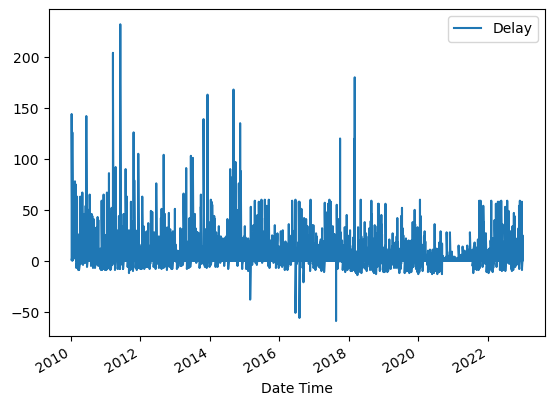

In [6]:
train_data.plot.line(x = 'Date Time', y = 'Delay')
plt.show()

/var/folders/53/6gcw2d7j5ss91wtplr59_y4r0000gn/T/ipykernel_40776/428411858.py:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.05`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(train_data, x = 'Delay', bw = 0.05 )


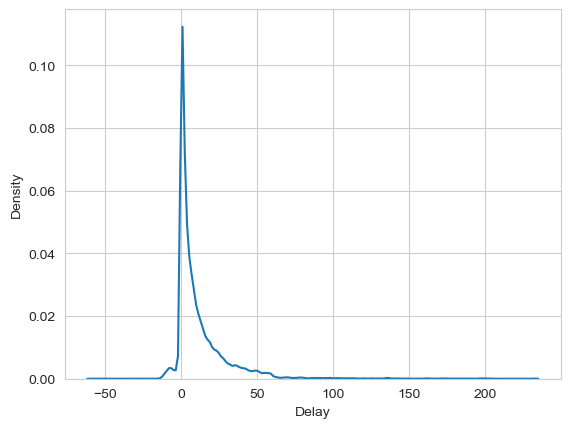

In [9]:
# Ordered Dealy Data

sns.set_style('whitegrid')
sns.kdeplot(train_data, x = 'Delay', bw = 0.05 )
plt.show()

[287.3542920607827, 287.31140367401116, 287.2780056797831, 287.2698831472348, 287.304006198589, 287.45073614838645, 287.7947792723812, 288.4661206010642, 289.3336164907543, 290.8654072626984, 293.0684396048896, 295.6392271926693, 298.8588228703619, 303.27403231524295, 306.9328488996786, 309.476018519476, 313.86002396590953, 316.51274235679017, 316.51274235679017, 316.51274235679017]


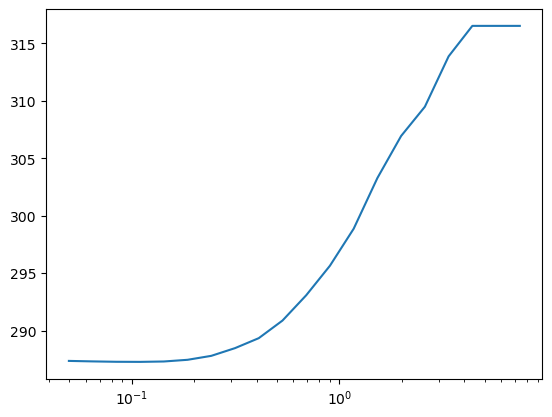

In [ ]:
# Running a Simple Lasso to Predict Delay Times

train_data['interact_week_station'] = train_data['Weekday'] + train_data['Station']
encoded_Data = pd.get_dummies(train_data, columns = ['interact_week_station'], dtype=float)

refrence_date = datetime.datetime(1970, 1, 1, 12, 0, 0)
def date_time_to_int(date_Time):
    time_dif = date_Time - refrence_date
    return time_dif.total_seconds() / 60 / 60 / 24
    
encoded_Data['int_time'] = encoded_Data['Date Time'].apply(date_time_to_int)

numerical_features = encoded_Data.columns.values.tolist()[8:]
X = encoded_Data[numerical_features]
X = (X - X.mean()) / X.std()
y = encoded_Data['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91)

test_alphas = np.exp(np.linspace(-3, 2, 20))

mses = []

for alpha in test_alphas:
    delay_lasso = Lasso(alpha = alpha)
    delay_lasso.fit(X_train, y_train)
    
    y_pred = delay_lasso.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)

print(mses)

plt.plot(test_alphas, mses)
plt.xscale('log')
plt.show()

alpha = test_alphas[np.argmin(mses)]

y_pred_train = delay_lasso.predict(X_train) 

delay_lasso = Lasso(alpha = alpha)
delay_lasso.fit(X_train, y_train)

y_pred = delay_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mses.append(mse)

mse_train = mean_squared_error(y_train, y_pred_train)

mse = mean_squared_error(y_test, y_pred)

287.2698831472348
360.479965606086
13489
12960   -0.777487
770      1.572312
4377     0.787087
7182     0.310964
14230   -1.033771
           ...   
10309   -0.259238
15022   -1.180440
217      1.670076
12602   -0.714753
1790     1.409844
Name: int_time, Length: 13489, dtype: float64


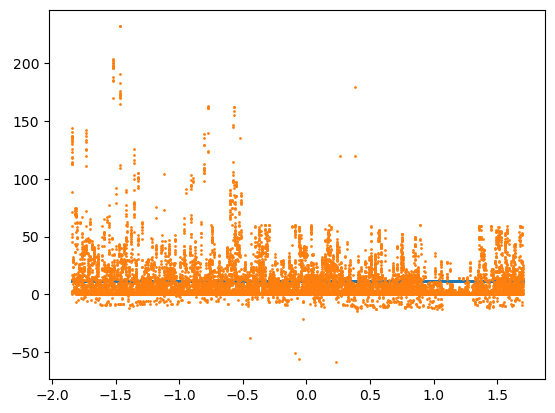

In [ ]:
#observe

print(mse)
print(mse_train)

plt.scatter(X_train['int_time'], y_pred_train, s = 1)
plt.scatter(X_train['int_time'], y_train, s = 1)
plt.show()